# Text Recognition Model: Training and Tuning

> NOTE: This sample notebook has been executed in a laptop without a GPU, hence the bad results.

In [ ]:
# pip install googledrivedownloader

In [1]:
from tfgpkg.recognition import DataUnpack, DataGen
from tfgpkg.recognition.word import StringVectorizer, RecognitionNet, Arch
from tfgpkg.recognition.datagen import DataGen
from tensorflow import keras

from google_drive_downloader import GoogleDriveDownloader as gdd
from shutil import make_archive, rmtree as rm_dir
from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import h5py as h5
import cv2
import os

In [3]:
tf.__version__

'2.2.0'

### Data Download (just once)

In [2]:
dataset_dest_dir = "datasets"
os.makedirs(dataset_dest_dir, exist_ok=True)

In [ ]:
drive_ids = {
    "spanish": "1Xt_Mq-Alg0yptfKgoxXoD-O0-Iyj5-2s",
    "iam": "11pUW60azvr722I7LaKS9s2pzwm_Con6V",
    "rimes": "1wb4CEHOV0JSIt2VaqXhGUeHfV5wzbHlg"
}
url_format = "https://drive.google.com/uc?id={}"

# gdd.download_file_from_google_drive(drive_ids["spanish"], dest_path=f"./{dataset_dest_dir}/spanish.h5")
# gdd.download_file_from_google_drive(drive_ids["iam"], dest_path=f"./{dataset_dest_dir}/iam.h5")
# gdd.download_file_from_google_drive(drive_ids["rimes"], dest_path=f"./{dataset_dest_dir}/rimes.h5")

In [8]:
MAX_WORD_LENGTH = 34  # 24

width, height = TARGET_SIZE = {
    "vsmall": (64, 16), # .25
    "small": (128, 32), # .50
    "medium": (192, 48), # .75
    "original": (256, 64)
}["medium"]

IMAGE_RATIO = width / height
print(IMAGE_RATIO)

4.0


### Data and Model Loading

In [ ]:
%%time

unzip_dataset_dest_dir = TemporaryDirectory(prefix="htr_").name
save_to_disk = False

# train_spa, test_spa, valid_spa 
# train_rimes, test_rimes, valid_rimes
# train_iam, test_iam, valid_iam

# train_set, test_set, valid_set

train_set, test_set, valid_set = DataUnpack.unpack(
    f"{dataset_dest_dir}/iam.h5",
    dest_dir=unzip_dataset_dest_dir,
    color=False,
    save_to_disk=save_to_disk,  # if the dataset is quite big or not enough ram
    target_size=TARGET_SIZE,
    aspect_ratio=IMAGE_RATIO
)

if save_to_disk:
    print(f"Unpacking dataset to {unzip_dataset_dest_dir}")

In [5]:
print(train_set[0].shape, train_set[1].shape)

(53839, 128, 32, 1) (53839,)


#### Create a new model...

In [ ]:
train_logdir = "training_logs"
os.makedirs(train_logdir, exist_ok=True)

net = RecognitionNet(
    logdir=train_logdir,
    input_size=(*TARGET_SIZE, 1),
    arch=Arch.Depthwise
    # charset=RecognitionNet.LATIN_CHAR
)

In [ ]:
# gated, 75% input size
# net.model.summary()

In [ ]:
# gated, original input size
# net.model.summary()

In [ ]:
# depthwise, original input size
# net.model.summary()

In [6]:
# octave, 75% input size
# net.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 192, 48, 1)] 0                                            
__________________________________________________________________________________________________
octave_conv2d (OctaveConv2D)    [(None, 96, 24, 14), 160         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 48, 12, 2)    8           octave_conv2d[0][1]              
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 96, 24, 14)   56          octave_conv2d[0][0]              
______________________________________________________________________________________________

In [12]:
# baseline, 75% input size
# net.model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 192, 48, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 24, 16)        160       
_________________________________________________________________
p_re_lu (PReLU)              (None, 96, 24, 16)        16        
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 24, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 24, 32)        4640      
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 96, 24, 32)        32        
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 24, 32)        128   

#### or import a trained one!

In [11]:
train_logdir = "training_logs"
trained_model_dir = "trained_models"
trained_model_name = "baseline_iam_small"


os.makedirs(train_logdir, exist_ok=True)

net = RecognitionNet.load_chkpt("./{trained_model_dir}/{trained_model_name}")

### Data Augmentation

In [13]:
BATCH_SIZE = 256

train_opts = dict(width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2, shear_range=0.2)

train_gen, test_gen, valid_gen = DataGen(train_set, test_set, valid_set, train_opts).from_tuple(BATCH_SIZE)

In [14]:
import gc

_ = gc.collect()

### Train the model

In [14]:
train_gen.reset()
valid_gen.reset()

In [15]:
%%time

EPOCHS = 20

training_results = net.model.fit(
    train_gen,
    steps_per_epoch=train_gen.n // BATCH_SIZE,
    validation_data=valid_gen,
    validation_steps=valid_gen.n // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=net.callbacks,
    verbose=1
)

Epoch 1/20
210/210 [==============================] - 44s 207ms/step - loss: 17.2201 - val_loss: 39.3090 - lr: 0.0010
Epoch 2/20
210/210 [==============================] - 43s 203ms/step - loss: 13.4741 - val_loss: 12.5752 - lr: 0.0010
Epoch 3/20
210/210 [==============================] - 47s 223ms/step - loss: 12.3051 - val_loss: 20.8910 - lr: 0.0010
Epoch 4/20
210/210 [==============================] - 42s 199ms/step - loss: 10.9767 - val_loss: 10.2916 - lr: 0.0010
Epoch 5/20
210/210 [==============================] - 40s 193ms/step - loss: 9.8539 - val_loss: 8.5381 - lr: 0.0010
Epoch 6/20
210/210 [==============================] - 41s 194ms/step - loss: 8.8273 - val_loss: 9.1339 - lr: 0.0010
Epoch 7/20
210/210 [==============================] - 41s 193ms/step - loss: 8.0070 - val_loss: 11.9160 - lr: 0.0010
Epoch 8/20
210/210 [==============================] - 44s 210ms/step - loss: 7.3156 - val_loss: 7.3793 - lr: 0.0010
Epoch 9/20
210/210 [==============================] - 43s 206ms

#### Check the statistics

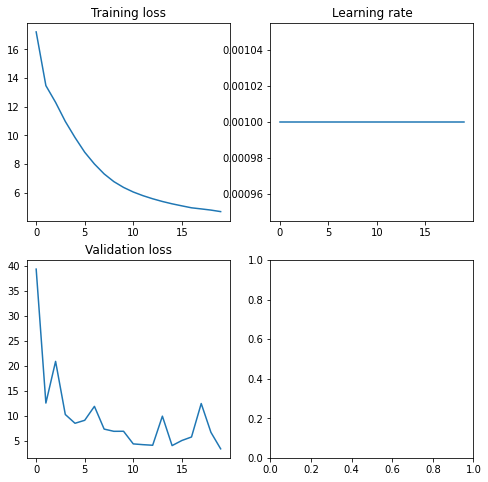

In [16]:
_, axes = plt.subplots(2,2, figsize=(8,8))
axes = axes.flatten()

axes[0].plot(training_results.history["loss"])
axes[0].set_title("Training loss")

axes[1].plot(training_results.history["lr"])
axes[1].set_title("Learning rate")

axes[2].plot(training_results.history["val_loss"])
axes[2].set_title("Validation loss")

plt.show()

#### Compute the WER and CER

In [17]:
test_gen.reset()

predictions, _ = net.predict(
    test_gen,
    steps=test_gen.n // BATCH_SIZE,
    # batch_size=BATCH_SIZE,
    verbose=1
)

print(f"\n{len(predictions)}")

# predictions = np.array(predictions)

Model Predict
68/68 [==============================] - 2s 36ms/step
CTC Decode


Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


68/68 [==============================] - 89s 1s/step

17408


In [18]:
predictions2 = np.array([np.array(v[0]).flatten() for v in predictions])
predictions2[:3]

array([array([16]), array([4]), array([4])], dtype=object)

In [19]:
vectorizer = StringVectorizer()

true_labels = [vectorizer.decode(encoded_vector) for encoded_vector in test_gen.y]
pred_labels = [vectorizer.decode(encoded_vector) for encoded_vector in predictions2]

In [20]:
RecognitionNet.compute_cer(true_labels, pred_labels) # the closer to 1.0, the worse

0.9594686648501363

In [21]:
wer_results = [RecognitionNet.compute_wer(t, p) for t, p in zip(true_labels, pred_labels)]

print(np.mean(wer_results))
# the closer to 0.0, the better

4.563074448529412


In [17]:
import gc

# del train_set, valid_set, train_gen, valid_gen

_ = gc.collect()

#### Optionally: Post-training quantization

##### Save to protobuf

In [22]:
trained_model_dir = "trained_models"
trained_model_name = "_".join(["baseline", "iam", "50"])

os.makedirs(trained_model_dir, exist_ok=True)

net.model.save(f"./{trained_model_dir}/{trained_model_name}_{EPOCHS}e")
make_archive(
    f"./{trained_model_dir}/{trained_model_name}_{EPOCHS}e",
    "zip",
    f"./{trained_model_dir}/{trained_model_name}_{EPOCHS}e/"
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./trained_models/baseline_iam_50_20e/assets


'/home/pachacho/Documents/text-processing/playground/trained_models/baseline_iam_50_20e.zip'

In [29]:
# !export PATH=$PATH:/home/pachacho/miniconda3/envs/deep/bin/toco_from_protos

In [30]:
converter = tf.lite.TFLiteConverter.from_keras_model(net.model)
# converter = tf.lite.TFLiteConverter.from_saved_model(f"./{trained_model_dir}/{trained_model_name}_{EPOCHS}e")

converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.target_spec.supported_ops = [
    # tf.lite.OpsSet.TFLITE_BUILTINS
    # tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8
]

tflife_quant_model = converter.convert()

INFO:absl:Using experimental converter: If you encountered a problem please file a bug. You can opt-out by setting experimental_new_converter=False


ConverterError: Could not find toco_from_protos binary, make sure
your virtualenv bin directory or pip local bin directory is in your path.
In particular, if you have installed TensorFlow with --user, make sure you
add the install directory to your path.

For example:
Linux: export PATH=$PATH:~/.local/bin/
Mac: export PATH=$PATH:~/Library/Python/<version#>/bin

Alternative, use virtualenv.

#### Evaluate the test dataset

In [23]:
test_gen.reset()

net.model.evaluate(
    test_gen,
    steps=test_gen.n // BATCH_SIZE,
    batch_size=BATCH_SIZE,
    verbose=1
)

68/68 [==============================] - 7s 106ms/step - loss: 3.4853


3.4852795600891113

#### Test a network prediction

In [24]:
test_gen.reset()
test_batch = test_gen.next()

(256, 192, 48, 1) (256, 34)
was


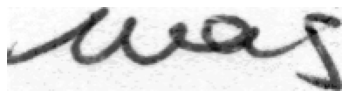

In [25]:
from keras.preprocessing.image import load_img, img_to_array

vectorizer = StringVectorizer()

print(test_batch[0].shape, test_batch[1].shape)

sample_idx = np.random.randint(BATCH_SIZE)

test_vector = test_batch[1][sample_idx, :]
print(vectorizer.decode(test_vector))

test_image = test_batch[0][sample_idx,:,:,0]
plt.imshow(test_image.transpose(), cmap="gray")
plt.axis("off")
plt.show()

In [26]:
test_image_pred = np.expand_dims(test_image, axis=[0,-1])

preds, probs = net.predict(test_image_pred)

In [27]:
vector = list(preds[0][0])

predicted_text = vectorizer.decode(vector)

print(predicted_text)

tas


### Save the trained model to `protobuf` (portable) format

In [20]:
trained_model_dir = "trained_models"
trained_model_name = "_".join(["baseline", "iam", "50"])

os.makedirs(trained_model_dir, exist_ok=True)

net.model.save(f"./{trained_model_dir}/{trained_model_name}_{EPOCHS}e")
make_archive(
    f"./{trained_model_dir}/{trained_model_name}_{EPOCHS}e",
    "zip",
    f"./{trained_model_dir}/{trained_model_name}_{EPOCHS}e/"
)

INFO:tensorflow:Assets written to: ./trained_models/octave_iam_20e/assets


'/home/pachacho/Documents/text-processing/playground/trained_models/octave_iam_20e.zip'

#### End

In [ ]:
# remove the temporal directory in the end
if save_to_disk:
    rm_dir(dataset_dest_dir)